### 问题1：开发一个模型，捕捉得分发生时的比赛流程，并将其应用于一场或多场比赛。你的模型应该识别出哪位球员在比赛的特定时间表现得更好，以及他们的表现有多好。基于你的模型提供一个可视化来描述比赛流程。注意:在网球比赛中，发球的选手赢得分/局的 概率要高得多。你可能希望以某种方式把这个因素考虑到你的模型中。

具体而言的，捕捉网球选手在每一个game里的实时得分相对于捕捉每一场game的输赢是更加困难的

除了是否为发球方，与选手获得胜利的关键相关的原因还有：选手的疲惫程度、个人技术能力、比赛实时心态
* 针对个人技术能力，利用过去或者实时的选手得分情况进行计算
* 针对选手疲惫程度，利用选手的实时跑图总里程进行计算
* 针对比赛实时心态，利用是否出现发球失误、是否没有进行加时赛就取得胜利、是否在对方发球时获得得分等指标进行表示
基于此，构建了一套实时选手得分表现的评价体系，由下图所示：
![x_define](./images/x_define.png)

剔除了得分异常的样本,删除了配速有缺失的样本

In [71]:
import pandas as pd
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
df = pd.read_csv('Wimbledon_featured_matches.csv')
df.loc[(df.p1_score=='AD'),'p1_score'] = 50
df.loc[(df.p2_score=='AD'),'p2_score'] = 50
df['p1_score'] = df['p1_score'].astype(int)
df['p2_score'] = df['p2_score'].astype(int)

# df.loc[(df.speed_mph=='NA'),'speed_mph'] = 0

# df.dropna(subset=['speed_mph'],inplace=True)
df['speed_mph'].fillna(0, inplace=True)
df.to_excel('testdata.xlsx',index=False)

In [72]:
dffork = df;
dffork.loc[(dffork.winner_shot_type=='F'),'winner_shot_type'] = 1
dffork.loc[(dffork.winner_shot_type=='B'),'winner_shot_type'] = 2

dffork.loc[(dffork.serve_width=='B'),'serve_width'] = 0
dffork.loc[(dffork.serve_width=='BC'),'serve_width'] = 1
dffork.loc[(dffork.serve_width=='BW'),'serve_width'] = 2
dffork.loc[(dffork.serve_width=='C'),'serve_width'] = 3
dffork.loc[(dffork.serve_width=='W'),'serve_width'] = 4

dffork.loc[(dffork.serve_depth=='NCTL'),'serve_depth'] = 0
dffork.loc[(dffork.serve_depth=='CTL'),'serve_depth'] = 1

dffork['return_depth'].fillna(0, inplace=True)
dffork.loc[(dffork.return_depth=='ND'),'return_depth'] = 1
dffork.loc[(dffork.return_depth=='D'),'return_depth'] = 2

dffork['label'] = dffork['point_victor'].apply(lambda x: 1 if x == 1 else 0)


dffork.to_excel('spsspro.xlsx',index=False)

以p1球员为视角

In [73]:
x1_ls,x2_ls,x3_ls,x4_ls,x5_ls,x6_ls,x7_ls,x8_ls,x9_ls,x10_ls,x11_ls,\
x12_ls,x13_ls,x14_ls,x15_ls,x16_ls=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
label_ls = []
for match_id,set_no,game_no,point_no in zip(df.match_id,df.set_no,df.game_no,df.point_no):
    match = df[df.match_id==match_id]
    set_ = match[match.set_no==set_no]
    game_ = set_[set_.game_no==game_no]
    point_ = game_[game_.point_no==point_no]
    x1 = point_['p1_games'].values[0]
    x2 = point_['p1_score'].values[0] - point_['p2_score'].values[0]
    x3 = 1 if point_['server'].values[0] == 1 else 0
    x4 = 0 if x2<0 else 1
    x5 = point_['p1_sets'].values[0] - point_['p2_sets'].values[0]
    x6 = 1 if 1 in game_['p1_ace'].values else 0    # 是否打出ACE球
    x7 = 1 if 1 in game_['p1_winner'].values else 0 # 是否打出对手无法触及的球（程度低于ACE球）
    x8 = 1 if 1 in game_['p1_double_fault'].values else 0   # 是否出现双误
    x9 = 1 if 1 in game_['p1_unf_err'].values else 0    # 是否出现非受迫性失误
    x10 = game_['p1_net_pt_won'].sum()/game_['p1_net_pt'].sum() if game_['p1_net_pt'].sum()!= 0 else 0  #网前进攻得分比例
    x11 = set_['p1_break_pt_won'].sum()/set_['p1_break_pt'].sum() if game_['p1_break_pt'].sum()!= 0 else 0  #破发点得分比例

    index = match.index.tolist().index(point_.index.tolist()[0])    # 索引从0开始
    x12 = match.iloc[:index+1]['p1_distance_run'].sum()
    x13 = match.iloc[index-2:index+1]['p1_distance_run'].sum()
    x14 = point_['p1_distance_run'].values[0]   # 本局跑动距离
    x15 = point_['speed_mph'].values[0]
    x16 = x15*x3
    
    label = 1 if point_['point_victor'].values[0] == 1 else 0
    label_ls.append(label)
    x1_ls.append(x1)
    x2_ls.append(x2)
    x3_ls.append(x3)
    x4_ls.append(x4)
    x5_ls.append(x5)
    x6_ls.append(x6)
    x7_ls.append(x7)
    x8_ls.append(x8)
    x9_ls.append(x9)
    x10_ls.append(x10)
    x11_ls.append(x11)
    x12_ls.append(x12)
    x13_ls.append(x13)
    x14_ls.append(x14)
    x15_ls.append(x15)
    x16_ls.append(x16)
    

In [74]:
dataset = pd.DataFrame({'x1':x1_ls,'x2':x2_ls,'x3':x3_ls,'x4':x4_ls,'x5':x5_ls,'x6':x6_ls,'x7':x7_ls,'x8':x8_ls,'x9':x9_ls,'x10':x10_ls,'x11':x11_ls,'x12':x12_ls,'x13':x13_ls,'x14':x14_ls,'x15':x15_ls,'x16':x16_ls,'label':label_ls})
dataset

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,label
0,0,0,1,1,0,1,1,0,1,1.0,0.0,6.000,0.000,6.000,95.0,95.0,0
1,0,-15,1,0,0,1,1,0,1,1.0,0.0,11.253,0.000,5.253,118.0,118.0,1
2,0,0,1,1,0,1,1,0,1,1.0,0.0,25.053,25.053,13.800,120.0,120.0,0
3,0,-15,1,0,0,1,1,0,1,1.0,0.0,76.161,70.161,51.108,130.0,130.0,1
4,0,0,1,1,0,1,1,0,1,1.0,0.0,76.810,65.557,0.649,112.0,112.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,5,-15,1,0,0,0,1,0,1,1.0,0.0,6552.404,49.542,38.620,123.0,123.0,1
7280,5,0,1,1,0,0,1,0,1,1.0,0.0,6569.937,62.925,17.533,114.0,114.0,1
7281,5,15,1,1,0,0,1,0,1,1.0,0.0,6580.819,67.035,10.882,124.0,124.0,0
7282,5,0,1,1,0,0,1,0,1,1.0,0.0,6588.712,36.308,7.893,130.0,130.0,1


以p2球员为视角

In [75]:
x1_ls,x2_ls,x3_ls,x4_ls,x5_ls,x6_ls,x7_ls,x8_ls,x9_ls,x10_ls,x11_ls,x12_ls,x13_ls,x14_ls,x15_ls,x16_ls=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
xlabel_ls = []
for match_id,set_no,game_no,point_no in zip(df.match_id,df.set_no,df.game_no,df.point_no):
    match = df[df.match_id==match_id]
    set_ = match[match.set_no==set_no]
    game_ = set_[set_.game_no==game_no]
    point_ = game_[game_.point_no==point_no]
    x1 = point_['p2_games'].values[0]
    x2 = point_['p2_score'].values[0] - point_['p1_score'].values[0]
    x3 = 1 if point_['server'].values[0] == 2 else 0
    x4 = 0 if x2<0 else 1
    x5 = point_['p2_sets'].values[0] - point_['p1_sets'].values[0]
    x6 = 1 if 1 in game_['p2_ace'].values else 0    # 是否打出ACE球
    x7 = 1 if 1 in game_['p2_winner'].values else 0 # 是否打出对手无法触及的球（程度低于ACE球）
    x8 = 1 if 1 in game_['p2_double_fault'].values else 0   # 是否出现双误
    x9 = 1 if 1 in game_['p2_unf_err'].values else 0    # 是否出现非受迫性失误
    x10 = game_['p2_net_pt_won'].sum()/game_['p2_net_pt'].sum() if game_['p2_net_pt'].sum()!= 0 else 0  #网前进攻得分比例
    x11 = set_['p2_break_pt_won'].sum()/set_['p2_break_pt'].sum() if game_['p2_break_pt'].sum()!= 0 else 0  #破发点得分比例

    index = match.index.tolist().index(point_.index.tolist()[0])    # 索引从0开始
    
    x12 = match.iloc[:index+1]['p2_distance_run'].sum()
    x13 = match.iloc[index-2:index+1]['p2_distance_run'].sum()
    x14 = point_['p2_distance_run'].values[0]   # 本球跑动距离
    x15 = point_['speed_mph'].values[0]
    x16 = x15*x3
    
    xlabel = 1 if point_['point_victor'].values[0] == 2 else 0
    xlabel_ls.append(xlabel)
    x1_ls.append(x1)
    x2_ls.append(x2)
    x3_ls.append(x3)
    x4_ls.append(x4)
    x5_ls.append(x5)
    x6_ls.append(x6)
    x7_ls.append(x7)
    x8_ls.append(x8)
    x9_ls.append(x9)
    x10_ls.append(x10)
    x11_ls.append(x11)
    x12_ls.append(x12)
    x13_ls.append(x13)
    x14_ls.append(x14)
    x15_ls.append(x15)
    x16_ls.append(x16)
    

### 预处理后的数据如下：

In [76]:
datasetP2 = pd.DataFrame({'x1':x1_ls,'x2':x2_ls,'x3':x3_ls,'x4':x4_ls,'x5':x5_ls,'x6':x6_ls,'x7':x7_ls,'x8':x8_ls,'x9':x9_ls,'x10':x10_ls,'x11':x11_ls,'x12':x12_ls,'x13':x13_ls,'x14':x14_ls,'x15':x15_ls,'x16':x16_ls,'label':xlabel_ls})
datasetP2

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,label
0,0,0,0,1,0,0,1,0,0,0.5,0.0,7.840,0.000,7.840,95.0,0.0,1
1,0,15,0,1,0,0,1,0,0,0.5,0.0,14.934,0.000,7.094,118.0,0.0,0
2,0,0,0,1,0,0,1,0,0,0.5,0.0,34.742,34.742,19.808,120.0,0.0,1
3,0,15,0,1,0,0,1,0,0,0.5,0.0,110.373,102.533,75.631,130.0,0.0,0
4,0,0,0,1,0,0,1,0,0,0.5,0.0,111.186,96.252,0.813,112.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,4,15,0,1,0,0,1,0,0,0.0,0.0,6113.170,64.883,50.971,123.0,0.0,0
7280,4,0,0,1,0,0,1,0,0,0.0,0.0,6140.936,89.040,27.766,114.0,0.0,0
7281,4,-15,0,0,0,0,1,0,0,0.0,0.0,6159.264,97.065,18.328,124.0,0.0,1
7282,4,0,0,1,0,0,1,0,0,0.0,0.0,6169.801,56.631,10.537,130.0,0.0,0


#### 由于总match的里程量纲太大，我们对所有特征进行了标准化

In [77]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns = dataset.columns[:-1]
scaler.fit(dataset[columns].values)

columnsP2 = datasetP2.columns[:-1]
scaler.fit(datasetP2[columnsP2].values)

dataset[columns] = scaler.transform(dataset[columns].values)
datasetP2[columnsP2] = scaler.transform(datasetP2[columnsP2].values)

dataset.to_excel('标准化训练数据.xlsx',index=False)
datasetP2.to_excel('标准化训练数据P2.xlsx',index=False)

#### 验证提出的指标对于选手是否获得point得分是否具有显著影响，将数据导入到SPSS中进行二元logist回归分析以及多变量方差分析，判断这些指标的显著性，性能和效果如下

可以看到，二元逻辑回归的准确率在65.5，这对于预测一个选手在实际比赛中能否获得得分已经有了一个还不错的预测效果，至少可以说明这个模型是能够辅助用于评价选手的表现能力的。
* 另一方面，对于方程中的变量分析，发现其中一半的变量对于模型的预测是显著的，其中主要包括x2,x6,x7,x8,x9,x10,x14
#### 额外的，因为二元逻辑回归的性能本身是有限的，希望能够选取更加优秀的模型进行预测，所以采用了一些经典的机器学习算法进行对比，使用accuracy、recall、precision、f1和auc进行评价，使用5折交叉验证法进行验证，结果如下:

In [78]:
import warnings
warnings.filterwarnings("ignore")

def function(model):
    # 借助各种评价指标使用5折交叉验证
    auc = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='roc_auc').mean(),2)
    acc = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='accuracy').mean(),2)
    recall = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='recall').mean(),2)
    precision = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='precision').mean(),2)
    f1 = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='f1').mean(),2)
    return acc,recall,precision,f1,auc

model = LGBMClassifier(random_state=30,force_col_wise=True)
print(f'LGBMClassifier acc,recall,precision,f1,auc :{function(model)}')
model = XGBClassifier(random_state=50)
print(f'XGBClassifier acc,recall,precision,f1,auc :{function(model)}')
model = SVC(random_state=50)
print(f'SVC acc,recall,precision,f1,auc :{function(model)}')
model = MLPClassifier(random_state=60)
print(f'MLPClassifier acc,recall,precision,f1,auc :{function(model)}')
model = LogisticRegression(random_state=50)
print(f'LogisticRegression acc,recall,precision,f1,auc :{function(model)}')

# 试图使用随机森林，梯度提升树等模型
from sklearn import model_selection
from sklearn import tree
clf=tree.DecisionTreeClassifier()
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
print(f'clf acc,recall,precision,f1,auc :{function(clf)}')
print(f'rf acc,recall,precision,f1,auc :{function(rf)}')
print(f'gb acc,recall,precision,f1,auc :{function(gb)}')

# 试图使用回归树
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=42)
print(f'regressor acc,recall,precision,f1,auc :{function(regressor)}')

[LightGBM] [Info] Number of positive: 2975, number of negative: 2852
[LightGBM] [Info] Total Bins 954
[LightGBM] [Info] Number of data points in the train set: 5827, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510554 -> initscore=0.042224
[LightGBM] [Info] Start training from score 0.042224
[LightGBM] [Info] Number of positive: 2974, number of negative: 2853
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 5827, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510383 -> initscore=0.041537
[LightGBM] [Info] Start training from score 0.041537
[LightGBM] [Info] Number of positive: 2974, number of negative: 2853
[LightGBM] [Info] Total Bins 955
[LightGBM] [Info] Number of data points in the train set: 5827, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510383 -> initscore=0.041537
[LightGBM] [Info] Start training from score 0.041537
[LightGBM] [Info] Numb

LGBM的效果最好，相对于二元逻辑回归还有提升

[LightGBM] [Info] Number of positive: 2991, number of negative: 2836
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 5827, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513300 -> initscore=0.053213
[LightGBM] [Info] Start training from score 0.053213
[0.43056481 0.0621803  0.35373246 ... 0.89889787 0.51322761 0.32653083]
[0.2177912  0.02388031 0.3801286  ... 0.93439287 0.46697873 0.20728903]
[0.26014352 0.17849675 0.22591303 ... 0.76172633 0.69852826 0.61675419]
[0.32483351 0.01989716 0.22196273 ... 0.72257705 0.4929884  0.23897435]
[0.25873923 0.32537947 0.19828615 ... 0.75188093 0.66698455 0.66576515]
[0.35 0.08 0.37 ... 0.84 0.48 0.2 ]
[0.28522708 0.28109712 0.27159006 ... 0.82711167 0.67301368 0.70783253]


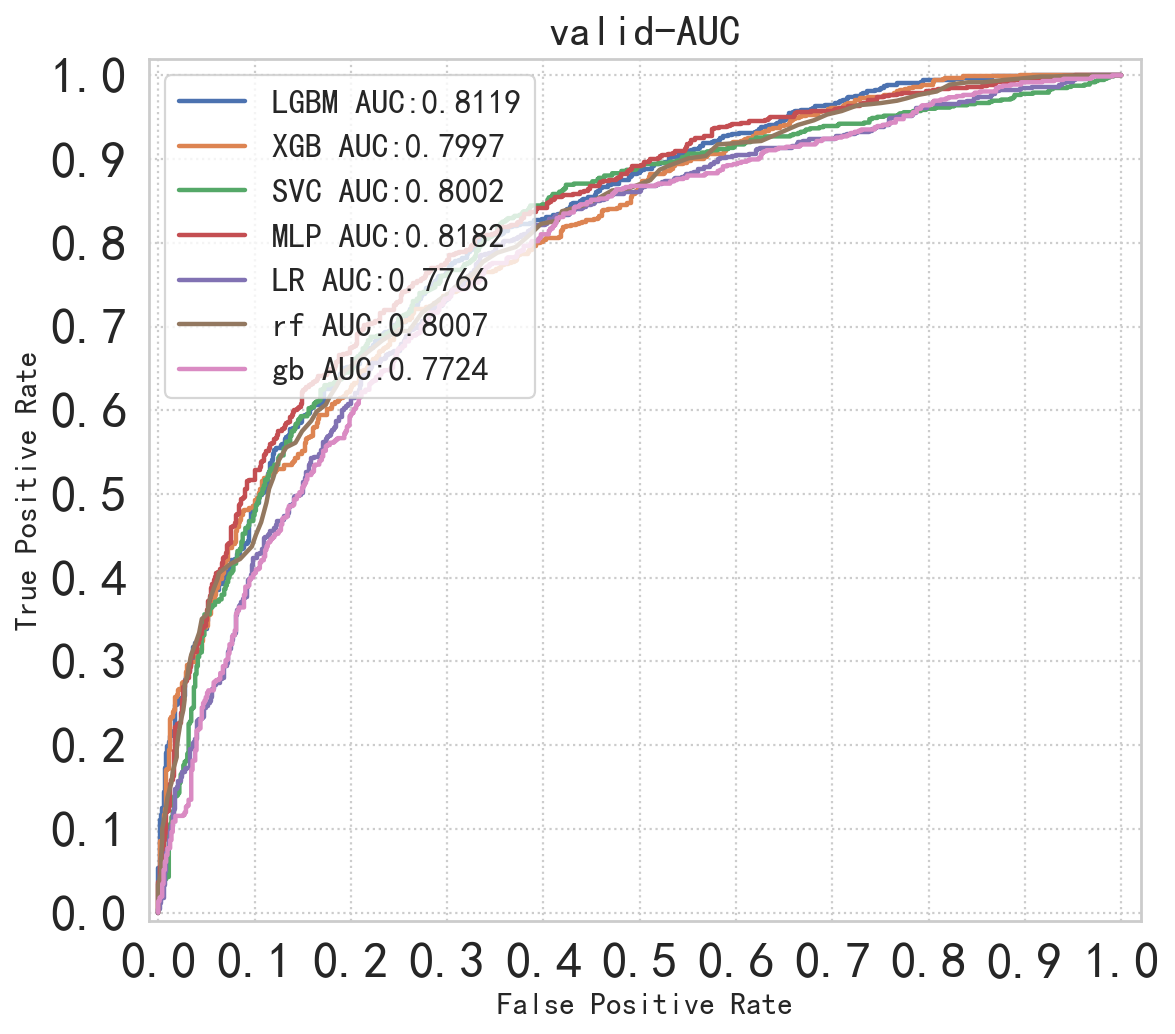

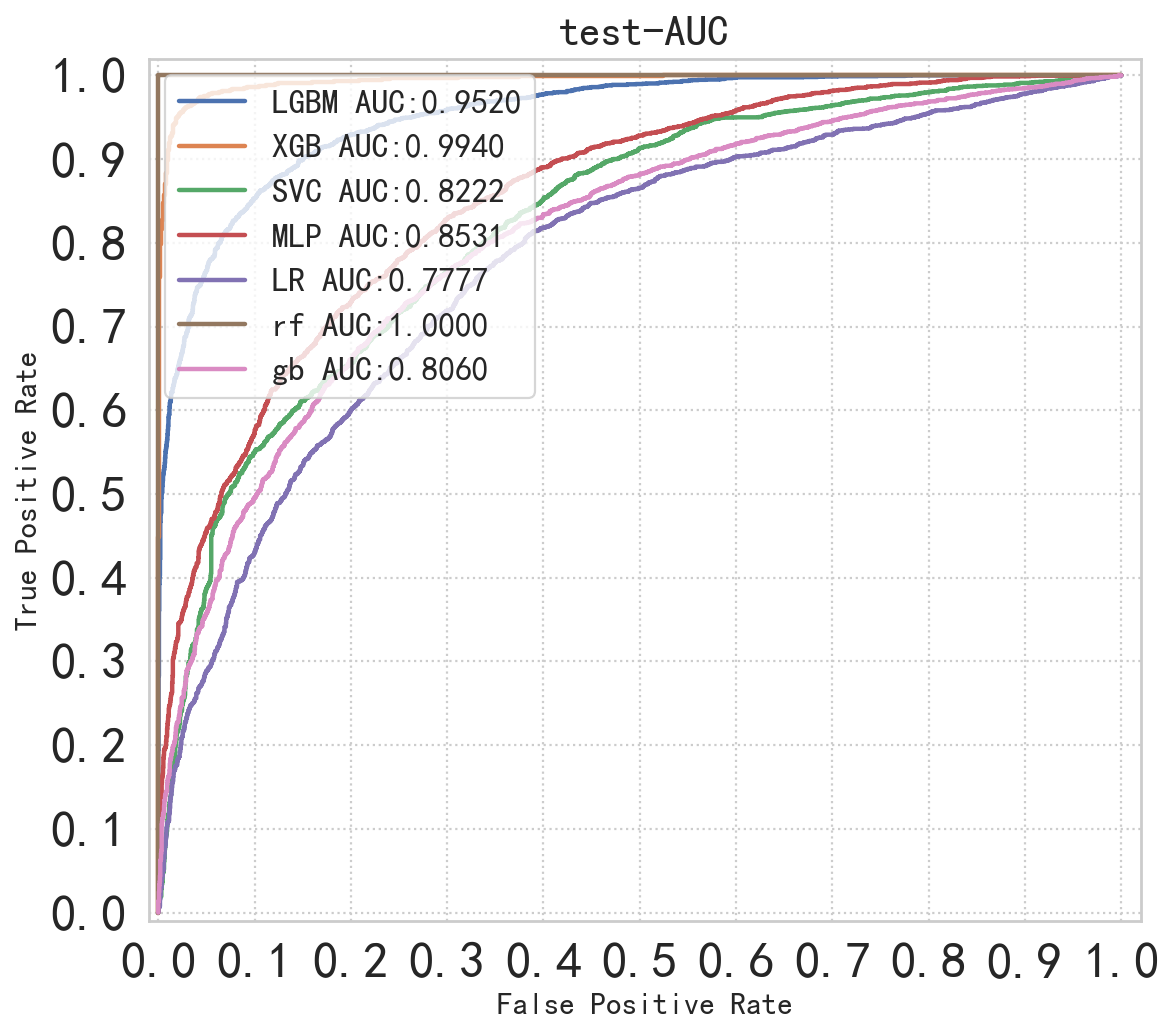

In [79]:
import numpy as np
from sklearn import metrics
def f(model_list,name_list,types='train'):
    plt.figure(figsize=(8, 7), dpi=80, facecolor='w')    # dpi:每英寸长度的像素点数；facecolor 背景颜色
    plt.xlim((-0.01, 1.02))  # x,y 轴刻度的范围
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))  #绘制刻度
    plt.yticks(np.arange(0, 1.1, 0.1))

    if types == 'test':
        for model,name in zip(model_list,name_list):
            # 取列别1的概率值
            ytest_prob = model.predict_proba(xvalid)[:,1]
            fpr, tpr, _ = metrics.roc_curve(yvalid, ytest_prob)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, '-', lw=2, label=f'{name} AUC:%.4f' % auc)  # 绘制AUC 曲线
            plt.title("valid-AUC")
    else:
        for model,name in zip(model_list,name_list):
            # 取列别1的概率值
            ytest_prob = model.predict_proba(xtrain)[:,1]
            fpr, tpr, _ = metrics.roc_curve(ytrain, ytest_prob)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, '-', lw=2, label=f'{name} AUC:%.4f' % auc)  # 绘制AUC 曲线
            plt.title("test-AUC")
    plt.legend(loc='lower left',fontsize=15)    # 设置显示标签的位置
    plt.xlabel('False Positive Rate', fontsize=14)   #绘制x,y 坐标轴对应的标签
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.tick_params(labelsize=23)

    plt.grid(True, ls=':')  # 绘制网格作为底板;b是否显示网格线；ls表示line style
    plt.savefig(f'问题1\\roc_auc({types}(采样前)).png',dpi=500)
    plt.show()
    
xtrain, xvalid, ytrain, yvalid = train_test_split(dataset[columns].values,dataset['label'].values,random_state=620,test_size=0.2)

model1 = LGBMClassifier(random_state=30)
model2 = XGBClassifier(random_state=50)
model3 = SVC(probability=True,random_state=50)
model4 = MLPClassifier(random_state=60)
model5 = LogisticRegression(random_state=50)
model7 = RandomForestClassifier(n_estimators=100, random_state=42)
model8 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
model9 = DecisionTreeRegressor(random_state=42)

model1.fit(xtrain,ytrain)
model2.fit(xtrain,ytrain)
model3.fit(xtrain,ytrain)
model4.fit(xtrain,ytrain)
model5.fit(xtrain,ytrain)

model7.fit(xtrain,ytrain)
model8.fit(xtrain,ytrain)
model9.fit(xtrain,ytrain)

f([model1,model2,model3,model4,model5,model7,model8],['LGBM','XGB','SVC','MLP','LR','rf','gb'],'test')
f([model1,model2,model3,model4,model5,model7,model8],['LGBM','XGB','SVC','MLP','LR','rf','gb'],'train')

#### 在这一基础上，重新训练模型，使用综合表现最好的LGBM模型，选取 2023 年温布尔登男单决赛中，20 岁的西班牙新星卡洛斯·阿尔卡拉兹击败了 36 岁的诺瓦 克·德约科维奇的经典对局进行实时的表现可视化
#### 查看的是卡洛斯·阿尔卡拉兹的实时得分表现

In [110]:
# 使用条件筛选找到所有match_id等于'2023-wimbledon-1701'的行，然后获取这些行的原始索引
index = df[df['match_id'] == '2023-wimbledon-1701'].index
# 打印行号
test = dataset.iloc[index]
testP2 = datasetP2.iloc[index]
train = dataset.drop(index,axis=0)
trainP2 = datasetP2.drop(index,axis=0)


In [111]:
model = LGBMClassifier(random_state=30)
model.fit(train[columns].values,train['label'].values)
pred = model.predict_proba(test[columns].values)
predP2 = model.predict_proba(testP2[columnsP2].values)
pred = pd.DataFrame({'实时得分':pred[:,1]})
predP2 = pd.DataFrame({'实时得分':predP2[:,1]})
pred

[LightGBM] [Info] Number of positive: 3550, number of negative: 3400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 6950, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510791 -> initscore=0.043172
[LightGBM] [Info] Start training from score 0.043172


,实时得分
0,0.075679
1,0.399791
2,0.185632
3,0.067768
4,0.369524
...,...
329,0.834885
330,0.879680
331,0.759556
332,0.892873


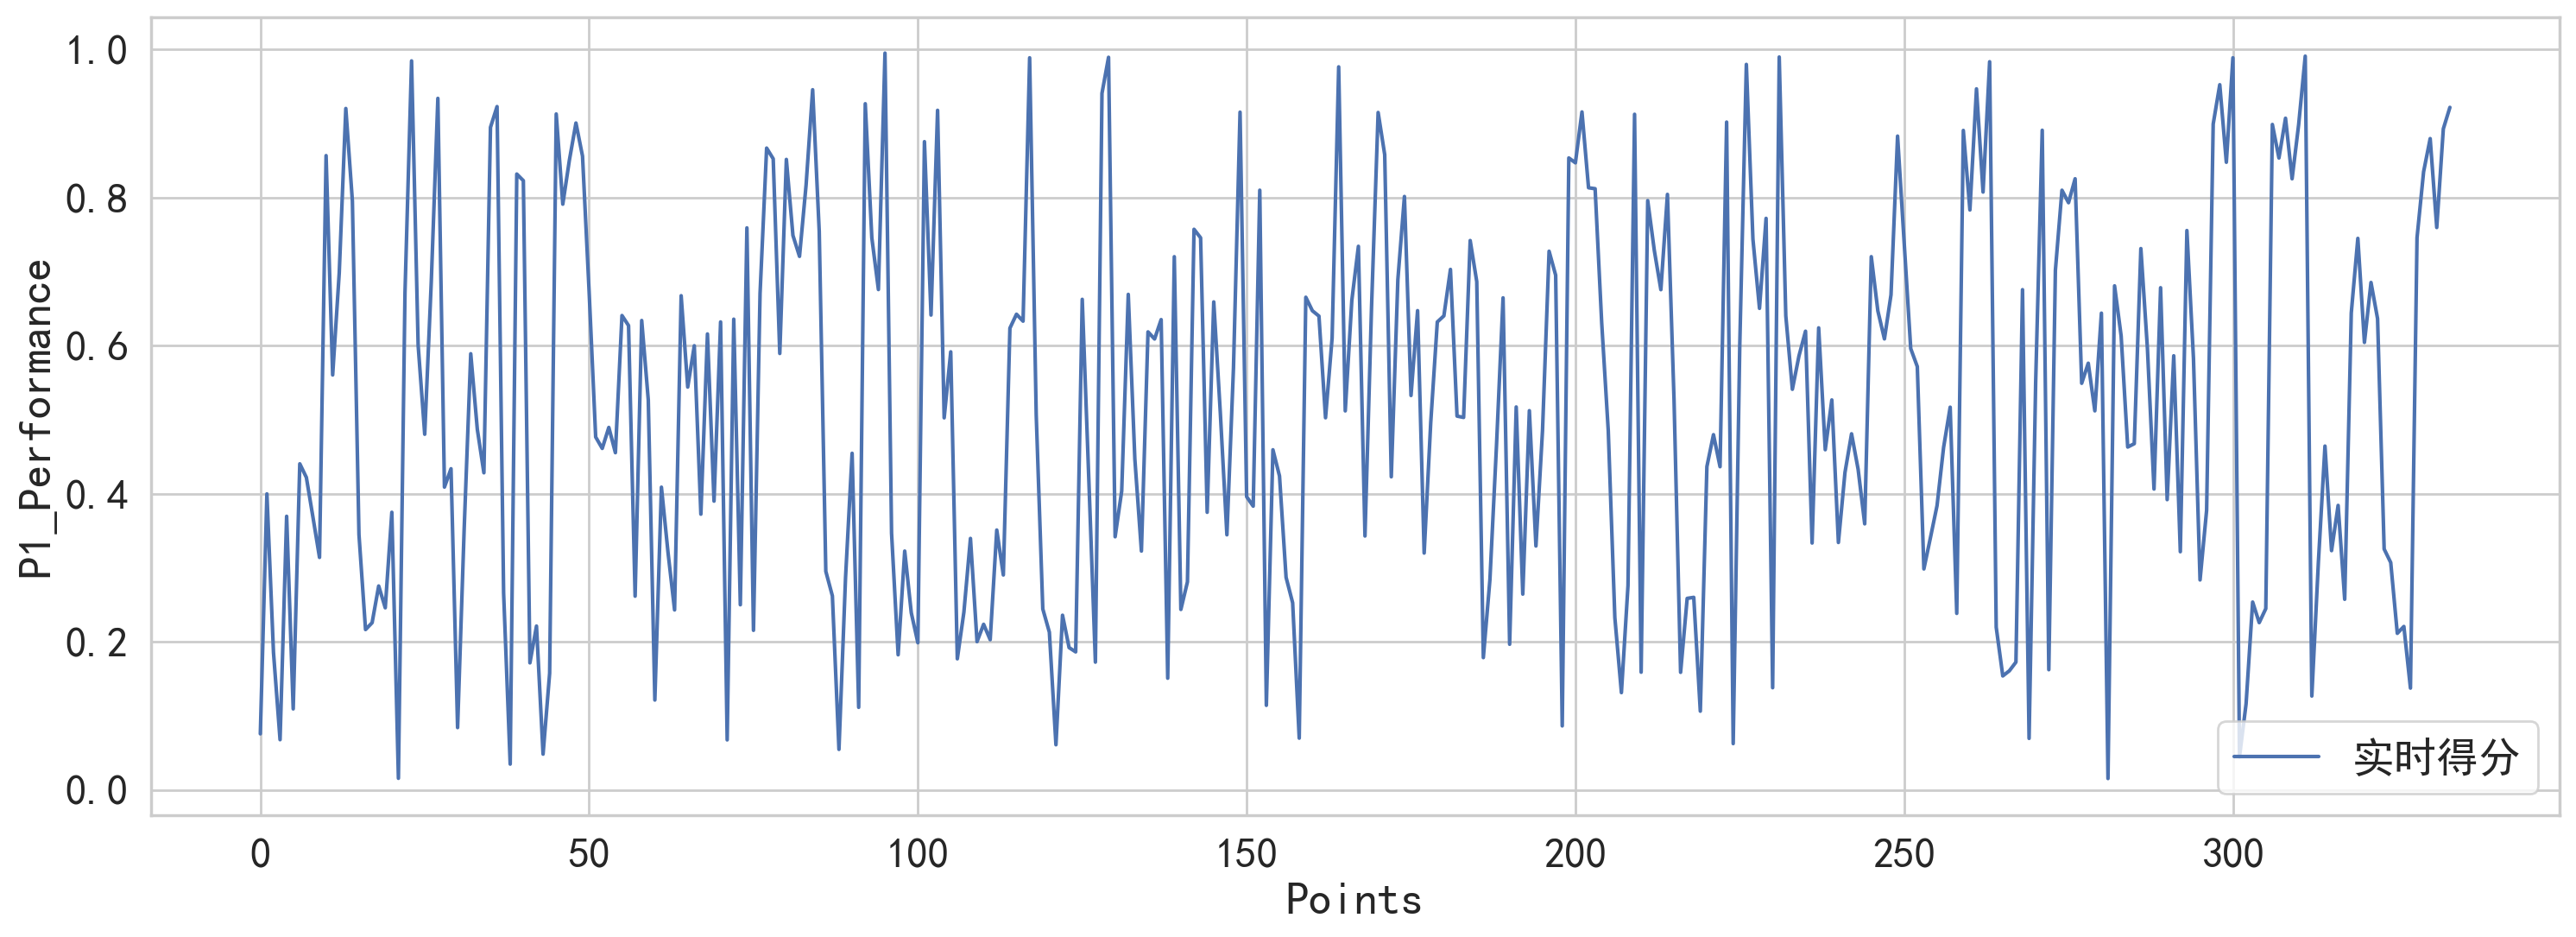

<Figure size 640x480 with 0 Axes>

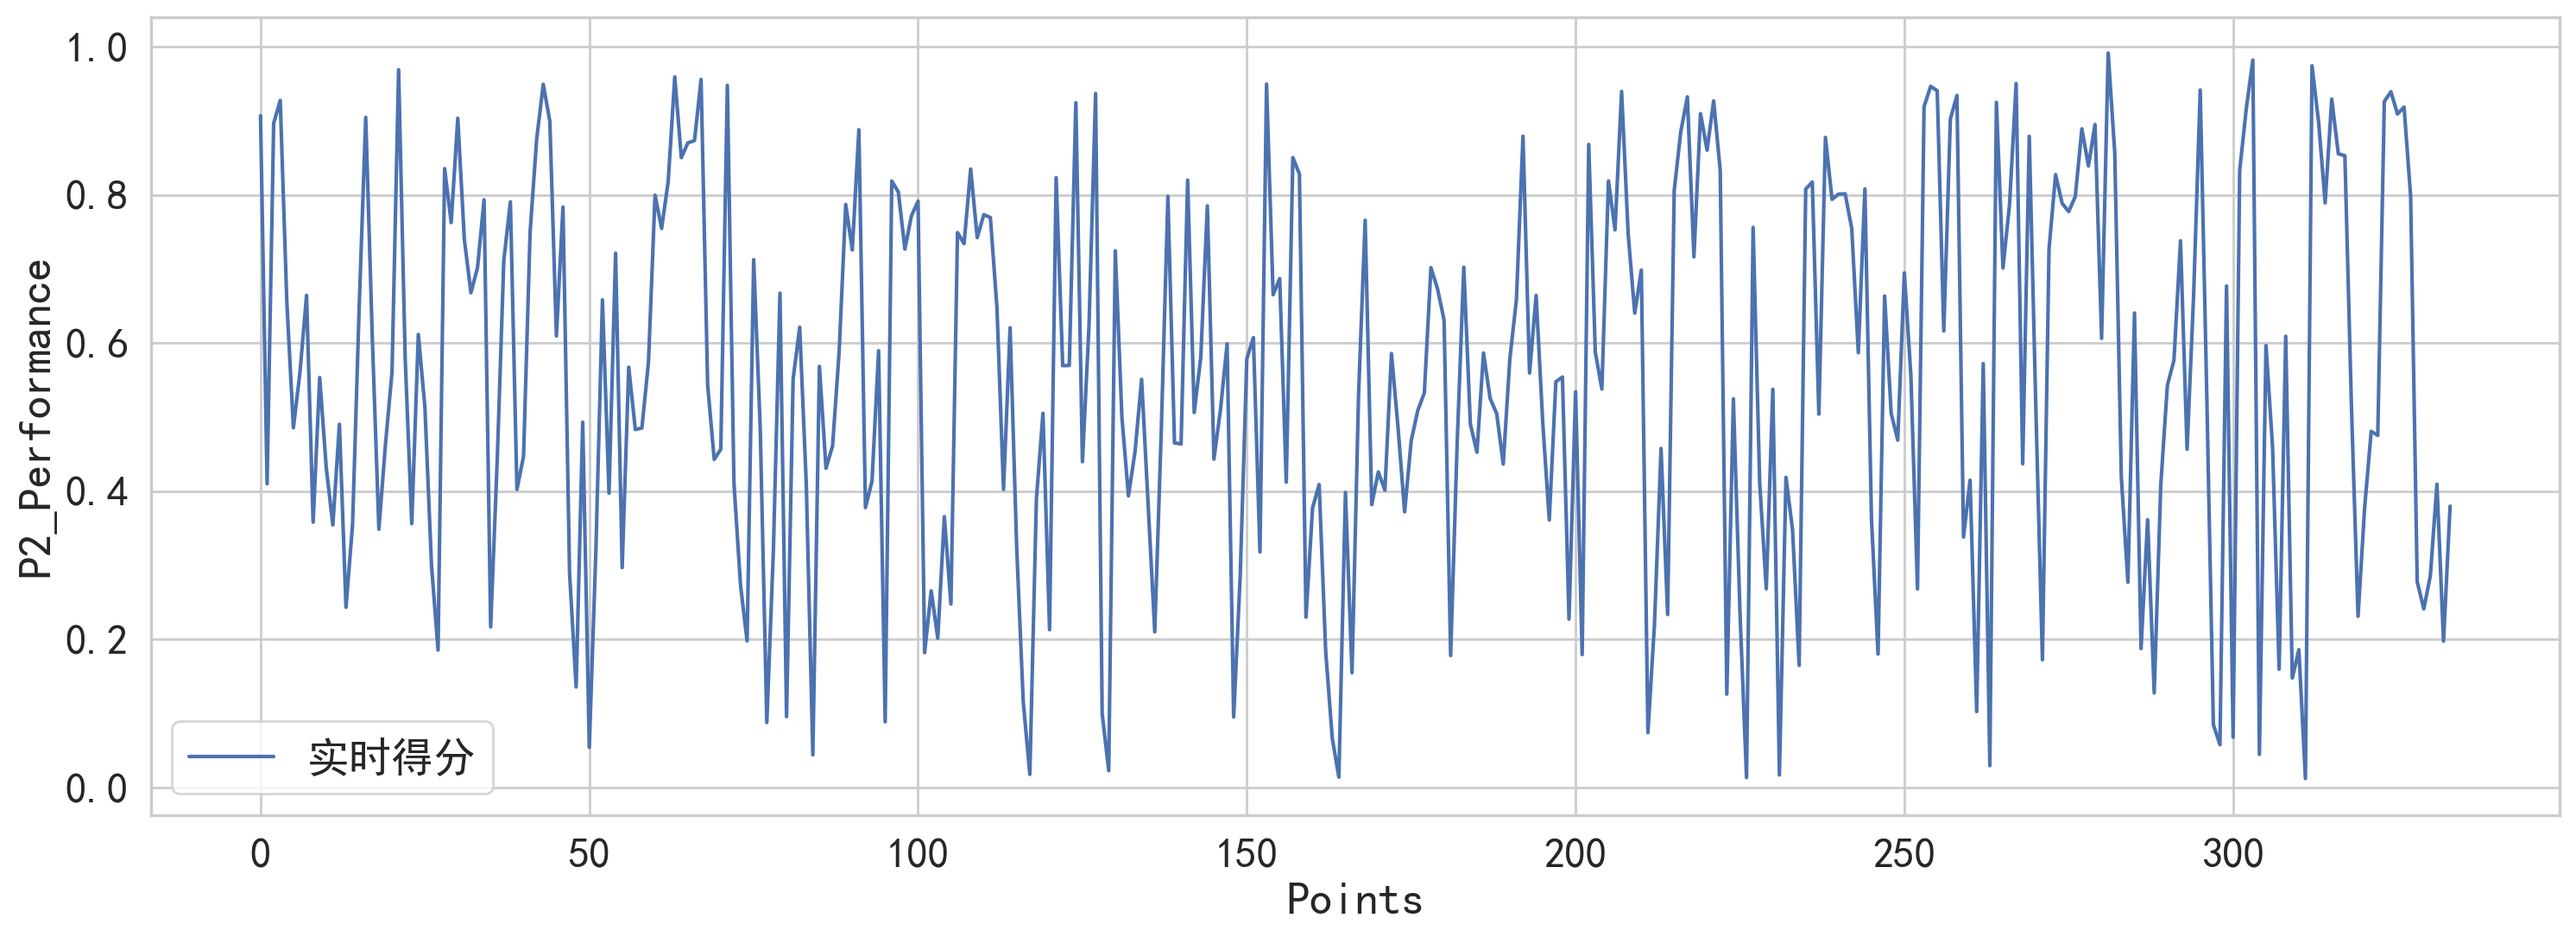

In [112]:
## 导入会使用到的库
%config InlineBackend.figure_format = 'retina'
%matplotlib inline    
import seaborn as sns
sns.set(font= "simhei",style="whitegrid",font_scale=1.6)
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False # 解决坐标轴的负号显示问题
import matplotlib.pyplot as plt
import plotly.express as px

# 实时得分的走势
pred.plot(kind = "line",figsize = (18,6)) #颜色,matplotlib
plt.xticks(rotation=0)
plt.xlabel("Points")
plt.ylabel("P1_Performance")
plt.savefig('问题1\\案例比赛走势.png',dpi=500)
plt.show()

plt.figure();
predP2.plot(kind = "line",figsize = (18,6)) #颜色,matplotlib
plt.xticks(rotation=0)
plt.xlabel("Points")
plt.ylabel("P2_Performance")
plt.show()

In [113]:
#输出重要性得分
f = pd.DataFrame({'col':list(columns),'score':model.feature_importances_}).sort_values(by='score')
f

,col,score
3,x4,4
5,x6,16
7,x8,33
2,x3,36
4,x5,74
6,x7,75
9,x10,84
8,x9,88
10,x11,99
0,x1,108


In [114]:
test

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,label,预测概率,momentValue
6950,0.000000,0.5000,0.0,1.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.000835,0.000000,0.036090,0.787234,0.000000,0,0.075679,-0.848642
6951,0.000000,0.3125,0.0,0.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.003822,0.000000,0.117955,0.893617,0.000000,1,0.399791,-0.460484
6952,0.000000,0.5000,0.0,1.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.004594,0.134145,0.030512,0.723404,0.000000,1,0.185632,-0.539890
6953,0.000000,0.6875,0.0,1.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.005386,0.130651,0.031283,0.851064,0.000000,0,0.067768,-0.674030
6954,0.000000,0.5000,0.0,1.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.007466,0.104604,0.082120,0.765957,0.000000,1,0.369524,-0.516437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,0.833333,0.3125,1.0,0.0,0.5,0.0,0.0,0.0,1.0,1.0,0.0,1.057668,0.229569,0.246213,0.872340,0.891304,1,0.834885,0.115126
7280,0.833333,0.5000,1.0,1.0,0.5,0.0,0.0,0.0,1.0,1.0,0.0,1.060499,0.291584,0.111778,0.808511,0.826087,1,0.879680,0.327723
7281,0.833333,0.6875,1.0,1.0,0.5,0.0,0.0,0.0,1.0,1.0,0.0,1.062255,0.310629,0.069376,0.879433,0.898551,0,0.759556,0.390881
7282,0.833333,0.5000,1.0,1.0,0.5,0.0,0.0,0.0,1.0,1.0,0.0,1.063529,0.168245,0.050320,0.921986,0.942029,1,0.892873,0.521187


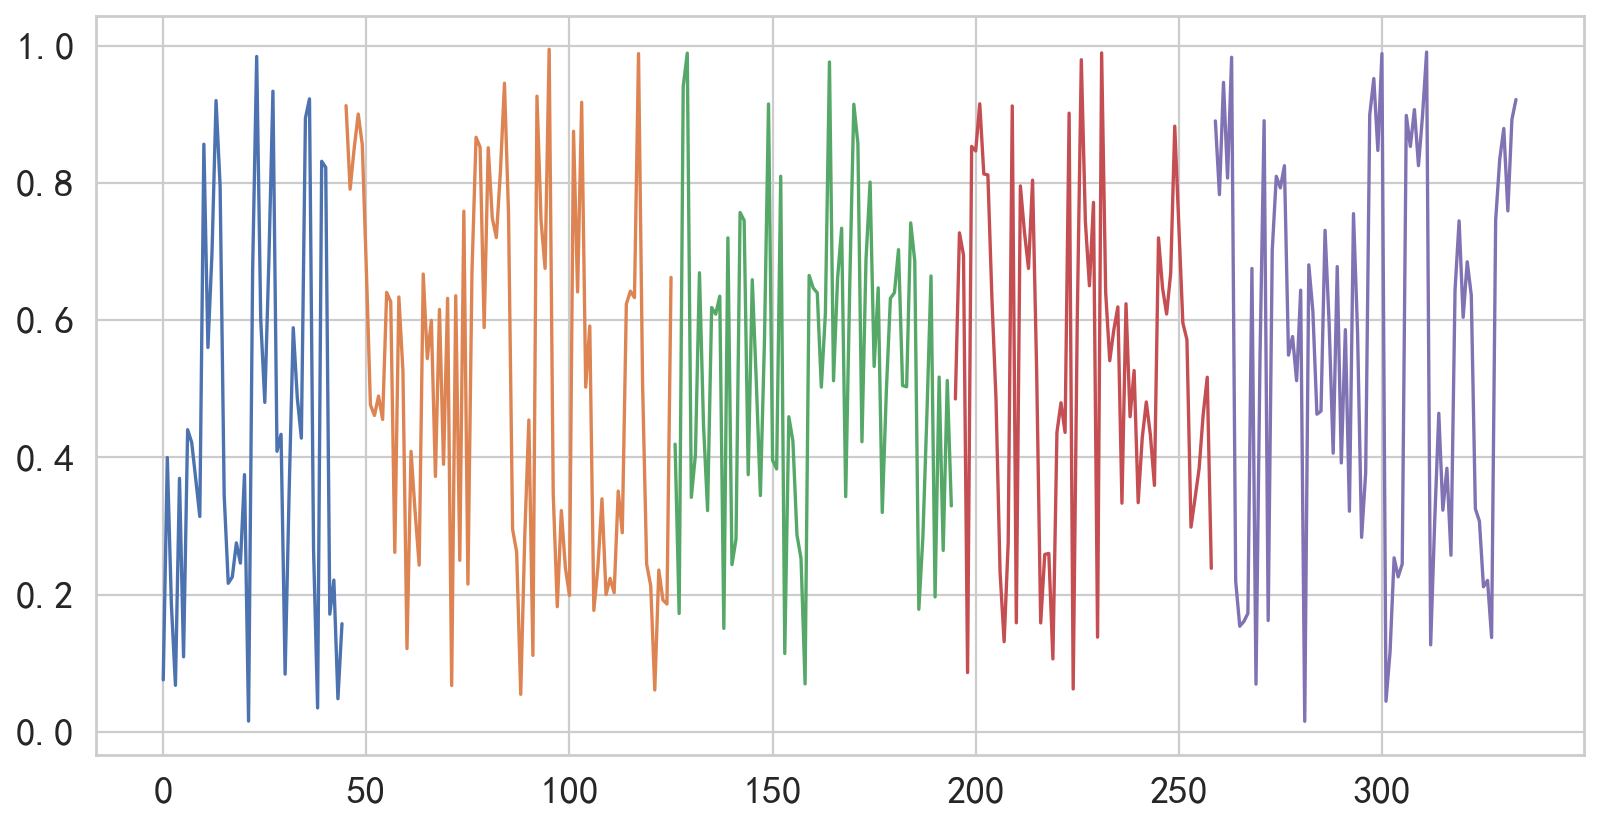

In [115]:
match1 = pred.iloc[:45]
match2 = pred.iloc[45:126]
match3 = pred.iloc[126:195]
match4 = pred.iloc[195:259]
match5 = pred.iloc[259:]

plt.figure(figsize=(12, 6), dpi=80, facecolor='w')
plt.plot(match1.index,match1.values)
plt.plot(match2.index,match2.values)
plt.plot(match3.index,match3.values)
plt.plot(match4.index,match4.values)
plt.plot(match5.index,match5.values)
plt.show()

In [116]:
match1.mean()

实时得分    0.439905
dtype: float64

In [117]:
match2.mean()

实时得分    0.506894
dtype: float64

In [118]:
match3.mean()

实时得分    0.528801
dtype: float64

In [119]:
match4.mean()

实时得分    0.540823
dtype: float64

In [120]:
match5.mean()

实时得分    0.56258
dtype: float64

定义势头的计算公式
$$y_{t}=\frac{x_{t}+(1-\alpha)x_{t-1}+...+(1-\alpha)^{t}x_{0}}{1+(1-\alpha)+...+(1-\alpha)^{t}}$$

In [121]:
import math
breakPointSuccess = pd.DataFrame(columns=['Index', 'momVal'])
breakPointFail = pd.DataFrame(columns=['Index', 'momVal'])
sevenPoint = pd.DataFrame(columns=['Index', 'momVal'])

pred_Momentum = pred;
originIndex = df[df['match_id'] == '2023-wimbledon-1701'].index;
multisum = 0; denominator = 0;
# 使用iterrows遍历DataFrame
for index, row in pred_Momentum.iterrows():
    # momentum.at[index,'momentValue'] = 1;
    # 分子处理，利用递归积
    multisum = multisum * (0.67) + 2*row['实时得分']-1;
    # 分母处理，利用递归和
    denominator = denominator + math.pow(0.67,index);
    momVal = multisum/denominator;
    # 判断是否破发成功
    # print(df.iloc[originIndex[index]]['server'])
    # if df.iloc[originIndex[index]]['server']
    if df.iloc[originIndex[index]]['p1_break_pt'] == 1 and df.iloc[originIndex[index]]['p1_break_pt_won'] == 1: # 破发成功
        momVal = momVal + 0.05;
        # print(index,momVal,'breakSuccess')
        #add row to end of DataFrame
        breakPointSuccess.loc[len(breakPointSuccess.index)] = [index, momVal]
        
    elif df.iloc[originIndex[index]]['p1_break_pt'] == 1 and df.iloc[originIndex[index]]['p1_break_pt_won'] == 0:   # 破发失败
        momVal = momVal + 0.03;
        # print(index,momVal,'breakFail')
        breakPointFail.loc[len(breakPointFail.index)] = [index, momVal]
        # breakPoint = breakPoint.append(temp_df, ignore_index=True)
    
    #判断是否抢7成功
    if df.iloc[originIndex[index]]['game_no'] == 13: # 抢七
        # print("here",index)
        if df.iloc[originIndex[index]]['p1_score'] >= 6 and (df.iloc[originIndex[index]]['p1_score'] - df.iloc[originIndex[index]]['p2_score']) >= 1 and df.iloc[originIndex[index]]['point_victor'] == 1: # 抢七成功
            momVal = momVal + 0.08;
            # print(index,momVal,'抢七成功')
            sevenPoint.loc[len(sevenPoint.index)] = [index, momVal]
        
        elif df.iloc[originIndex[index]]['p2_score'] >= 6 and (df.iloc[originIndex[index]]['p2_score'] - df.iloc[originIndex[index]]['p1_score']) >= 1 and df.iloc[originIndex[index]]['point_victor'] == 2: # 抢七失败
            momVal = momVal - 0.05;
            # print(index,momVal,'抢七失败')
            sevenPoint.loc[len(sevenPoint.index)] = [index, momVal]

    pred_Momentum.at[index,'momentValue'] = momVal;

#### 为第三问制作表格
立足p1的表格

In [122]:
import math
predP1Whole = model.predict_proba(dataset[columns].values)
predP1Whole = pd.DataFrame({'实时得分':predP1Whole[:,1]})
p1table = df;
p1table['预测概率'] = predP1Whole['实时得分']
datasetloadP1 = dataset;
datasetloadP1['预测概率'] = predP1Whole['实时得分']

multisumWholeP1 = 0; denominatorWholeP1 = 0;
subindex = 0;
# 使用iterrows遍历DataFrame
for index, row in p1table.iterrows():
    subindex = subindex + 1;
    # init操作
    if index == 0 or p1table.iloc[index]['match_id'] != p1table.iloc[index-1]['match_id']:
        multisumWholeP1 = 0; denominatorWholeP1 = 0; subindex = 0;
        # print(index,'换弹')
    
    # momentum.at[index,'momentValue'] = 1;
    # 分子处理，利用递归积
    multisumWholeP1 = multisumWholeP1 * (0.67) + 2 * row['预测概率']-1;
    # 分母处理，利用递归和
    denominatorWholeP1 = denominatorWholeP1 + math.pow(0.67,subindex);
    # print(denominatorWholeP1)

    momValWhole = multisumWholeP1/denominatorWholeP1;
    if p1table.iloc[index]['p1_break_pt'] == 1 and p1table.iloc[index]['p1_break_pt_won'] == 1: # 破发成功
        momValWhole = momValWhole + 0.05;
        
    elif p1table.iloc[index]['p1_break_pt'] == 1 and p1table.iloc[index]['p1_break_pt_won'] == 0:   # 破发失败
        momValWhole = momValWhole + 0.03;

    #判断是否抢7成功
    if p1table.iloc[index]['game_no'] == 13: # 抢七
        # print("here",index)
        if p1table.iloc[index]['p1_score'] >= 6 and (p1table.iloc[index]['p1_score'] - p1table.iloc[index]['p2_score']) >= 1 and p1table.iloc[index]['point_victor'] == 1: # 抢七成功
            momValWhole = momValWhole + 0.08;
        
        elif p1table.iloc[index]['p2_score'] >= 6 and (p1table.iloc[index]['p2_score'] - p1table.iloc[index]['p1_score']) >= 1 and p1table.iloc[index]['point_victor'] == 2: # 抢七失败
            momValWhole = momValWhole - 0.05;

    p1table.at[index,'momentValue'] = momValWhole;
    datasetloadP1.at[index,'momentValue'] = momValWhole;


p1table.to_excel('p1table.xlsx',index=False);
datasetloadP1.to_excel('第三问P1运动员.xlsx',index=False);


立足p2的表格

In [123]:
p2table = df;
predP2Whole = model.predict_proba(datasetP2[columnsP2].values)
predP2Whole = pd.DataFrame({'实时得分':predP2Whole[:,1]})
datasetloadP2 = datasetP2;
datasetloadP2['预测概率'] = predP2Whole['实时得分']

multisumWholeP2 = 0; denominatorWholeP2 = 0;
subindex = 0;
# 使用iterrows遍历DataFrame
for index, row in p2table.iterrows():
    subindex = subindex + 1;
    # init操作
    if index == 0 or p2table.iloc[index]['match_id'] != p2table.iloc[index-1]['match_id']:
        multisumWholeP2 = 0; denominatorWholeP2 = 0; subindex = 0;
        print(index,'换弹')
    
    # momentum.at[index,'momentValue'] = 1;
    # 分子处理，利用递归积
    multisumWholeP2 = multisumWholeP2 * (0.67) + 2 * row['预测概率']-1;
    # 分母处理，利用递归和
    denominatorWholeP2 = denominatorWholeP2 + math.pow(0.67,subindex);
    # print(denominatorWholeP1)

    momValWhole = multisumWholeP2/denominatorWholeP2;
    if p2table.iloc[index]['p2_break_pt'] == 1 and p2table.iloc[index]['p2_break_pt_won'] == 1: # 破发成功
        momValWhole = momValWhole + 0.05;
        
    elif p2table.iloc[index]['p2_break_pt'] == 1 and p2table.iloc[index]['p2_break_pt_won'] == 0:   # 破发失败
        momValWhole = momValWhole + 0.03;

    #判断是否抢7成功
    if p2table.iloc[index]['game_no'] == 13: # 抢七
        # print("here",index)
        if p2table.iloc[index]['p2_score'] >= 6 and (p2table.iloc[index]['p2_score'] - p2table.iloc[index]['p1_score']) >= 1 and p2table.iloc[index]['point_victor'] == 2: # 抢七成功
            momValWhole = momValWhole + 0.08;
        elif p2table.iloc[index]['p2_score'] >= 6 and (p2table.iloc[index]['p1_score'] - p2table.iloc[index]['p2_score']) >= 1 and p2table.iloc[index]['point_victor'] == 1: # 抢七失败
            momValWhole = momValWhole - 0.05;

    datasetloadP2.at[index,'momentValue'] = momValWhole;

datasetloadP2.to_excel('第三问P2运动员.xlsx',index=False);

0 换弹
300 换弹
501 换弹
635 换弹
972 换弹
1218 换弹
1550 换弹
1782 换弹
1972 换弹
2185 换弹
2503 换弹
2673 换弹
2948 换弹
3238 换弹
3423 换弹
3621 换弹
3788 换弹
4013 换弹
4287 换弹
4409 换弹
4695 换弹
4910 换弹
5105 换弹
5436 换弹
5707 换弹
5896 换弹
6179 换弹
6372 换弹
6589 换弹
6748 换弹
6950 换弹


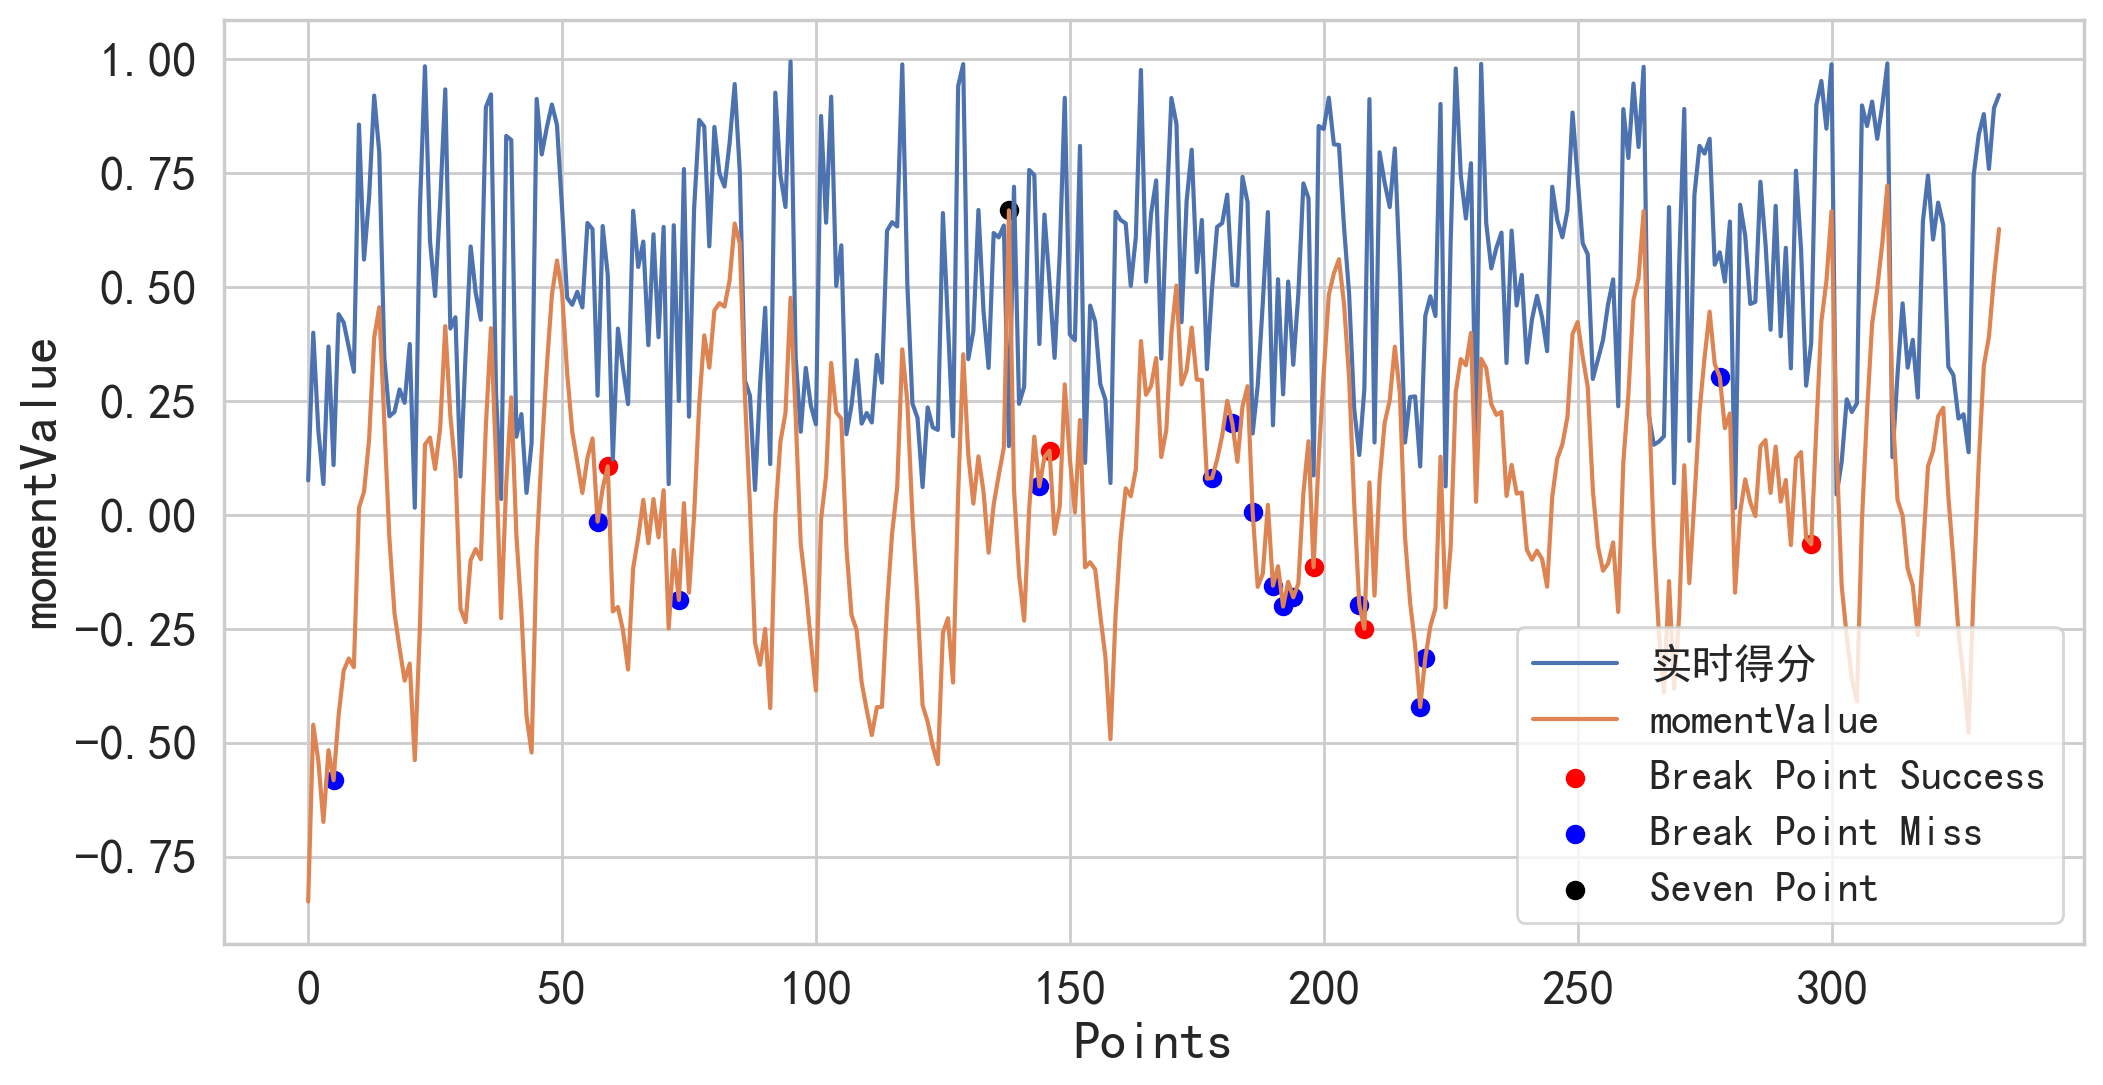

In [124]:
sns.set(font= "simhei",style="whitegrid",font_scale=1.6)
matplotlib.rcParams['axes.unicode_minus']=False # 解决坐标轴的负号显示问题

# 实时势头的走势
pred_Momentum.plot(kind = "line",figsize = (12,6)) #颜色,matplotlib
plt.xticks(rotation=0)
plt.xlabel("Points")
plt.ylabel("momentValue")
plt.scatter(breakPointSuccess['Index'], breakPointSuccess['momVal'], color='red', label='Break Point Success')
plt.scatter(breakPointFail['Index'], breakPointFail['momVal'], color='blue', label='Break Point Miss')
plt.scatter(sevenPoint['Index'], sevenPoint['momVal'], color='black', label='Seven Point')
plt.legend(loc='lower right', fontsize=15)
plt.show()

#### 真实比分

In [125]:
test_index = df[df['match_id'] == '2023-wimbledon-1701'].index
realBoard = df.iloc[test_index]
# 初始化playerA和playerB为列表而不是数组，初始分数为0
playerA = [0]
playerB = [0]

# 遍历DataFrame
for index, row in realBoard.iterrows():
    if row['point_victor'] == 1:
        # 玩家A得分，玩家B不变
        playerA.append(playerA[-1] + 1)
        playerB.append(playerB[-1])
    else:
        # 玩家B得分，玩家A不变
        playerA.append(playerA[-1])
        playerB.append(playerB[-1] + 1)

# 如果需要，可以在最后将列表转换为NumPy数组
playerA_array = np.array(playerA)
playerB_array = np.array(playerB)

print(playerA_array)
print(playerB_array)
realBoard

[  0   0   1   2   2   3   3   3   4   4   4   4   4   4   5   6   6   6
   7   8   8   8   8   8   9   9   9  10  11  11  11  11  11  12  12  12
  13  14  14  14  15  16  16  16  16  16  17  17  18  19  20  21  22  22
  22  22  23  24  24  25  26  26  27  28  28  29  29  29  29  30  31  31
  31  32  32  32  32  32  33  34  35  35  35  36  36  37  38  39  40  40
  40  40  40  41  42  43  44  44  45  45  45  45  45  46  47  48  49  50
  50  50  51  51  52  52  52  52  53  54  55  56  56  57  57  58  58  58
  58  58  58  59  60  61  61  62  63  63  63  64  65  66  67  67  67  68
  69  69  70  71  71  72  73  74  74  75  75  76  77  77  77  77  78  78
  78  78  79  80  81  82  83  83  83  83  84  85  85  86  86  87  88  88
  88  89  90  90  90  91  92  92  92  93  94  94  95  95  96  96  96  97
  98  99 100 101 102 102 103 104 105 106 106 107 107 107 108 109 110 111
 112 113 113 114 114 114 114 114 115 115 116 117 117 117 118 118 119 119
 120 121 121 121 122 123 123 124 124 124 125 125 12

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth,label,预测概率,momentValue
6950,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,0:00:00,1,1,1,0,0,0,...,5.661,4.341,1,111.0,4,1,2,0,0.075679,-0.848642
6951,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,0:00:25,1,1,2,0,0,0,...,18.502,22.307,4,126.0,2,0,1,1,0.399791,-0.460484
6952,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,0:01:19,1,1,3,0,0,0,...,4.786,2.926,2,102.0,2,0,1,1,0.185632,-0.539890
6953,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,0:02:17,1,1,4,0,0,0,...,4.907,4.209,1,120.0,1,1,1,0,0.067768,-0.674030
6954,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,0:03:02,1,1,5,0,0,0,...,12.881,8.676,2,108.0,4,1,1,1,0.369524,-0.516437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,4:39:58,5,10,330,2,2,5,...,38.620,50.971,11,123.0,3,0,2,1,0.834885,0.115126
7280,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,4:40:43,5,10,331,2,2,5,...,17.533,27.766,5,114.0,4,0,1,1,0.879680,0.327723
7281,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,4:41:20,5,10,332,2,2,5,...,10.882,18.328,4,124.0,4,0,2,0,0.759556,0.390881
7282,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,4:41:52,5,10,333,2,2,5,...,7.893,10.537,1,130.0,3,0,2,1,0.892873,0.521187


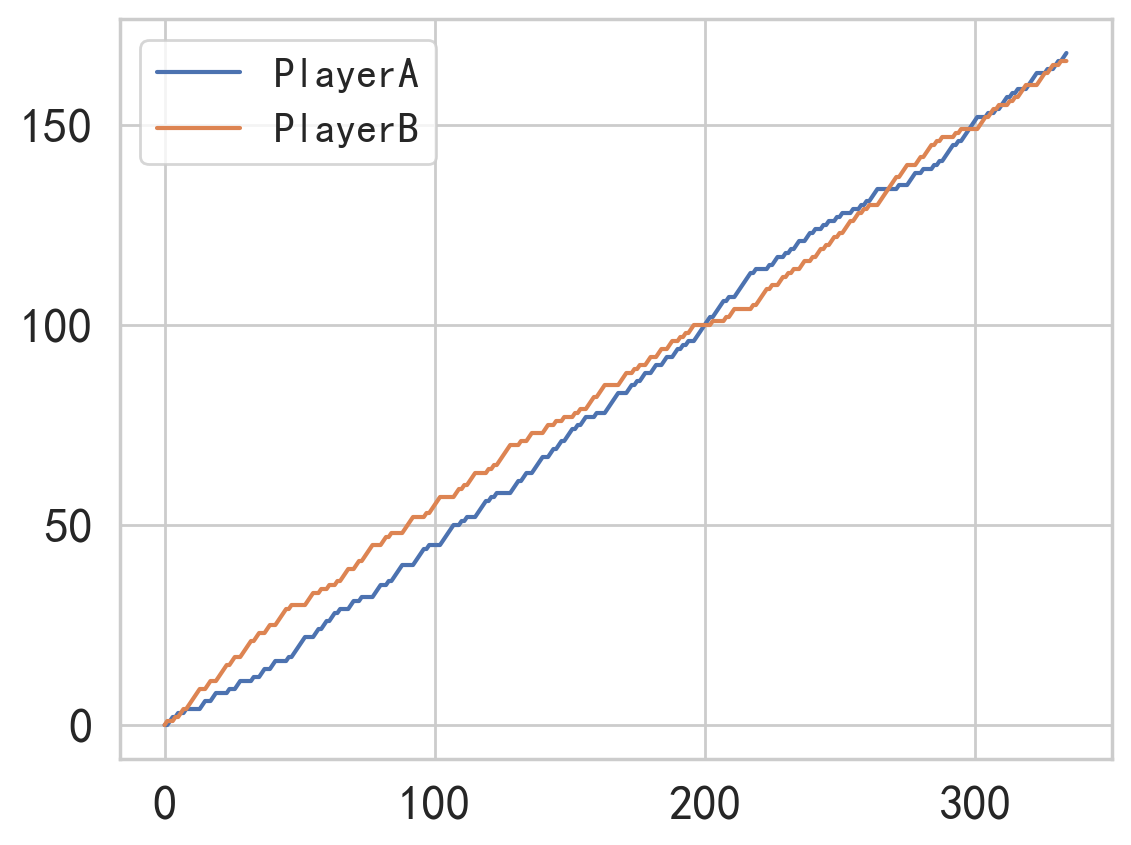

In [126]:
plt.figure()
# 首先绘制线条，并确保每条线都有label参数
plt.plot(playerA_array, label='PlayerA')
plt.plot(playerB_array, label='PlayerB')
# 确保所有绘图命令执行后再调用legend
plt.legend(loc='upper left', fontsize=15)


In [127]:
# 5张子图
# 第一盘比赛


In [128]:
# 第二盘比赛

In [129]:
# 第三盘比赛

In [130]:
# 第四盘比赛

In [131]:
# 第五盘比赛

#### 第二题
选取经典案例比赛分析势头与局势变化是否具有相关性，以Carlos Alcaraz为视角

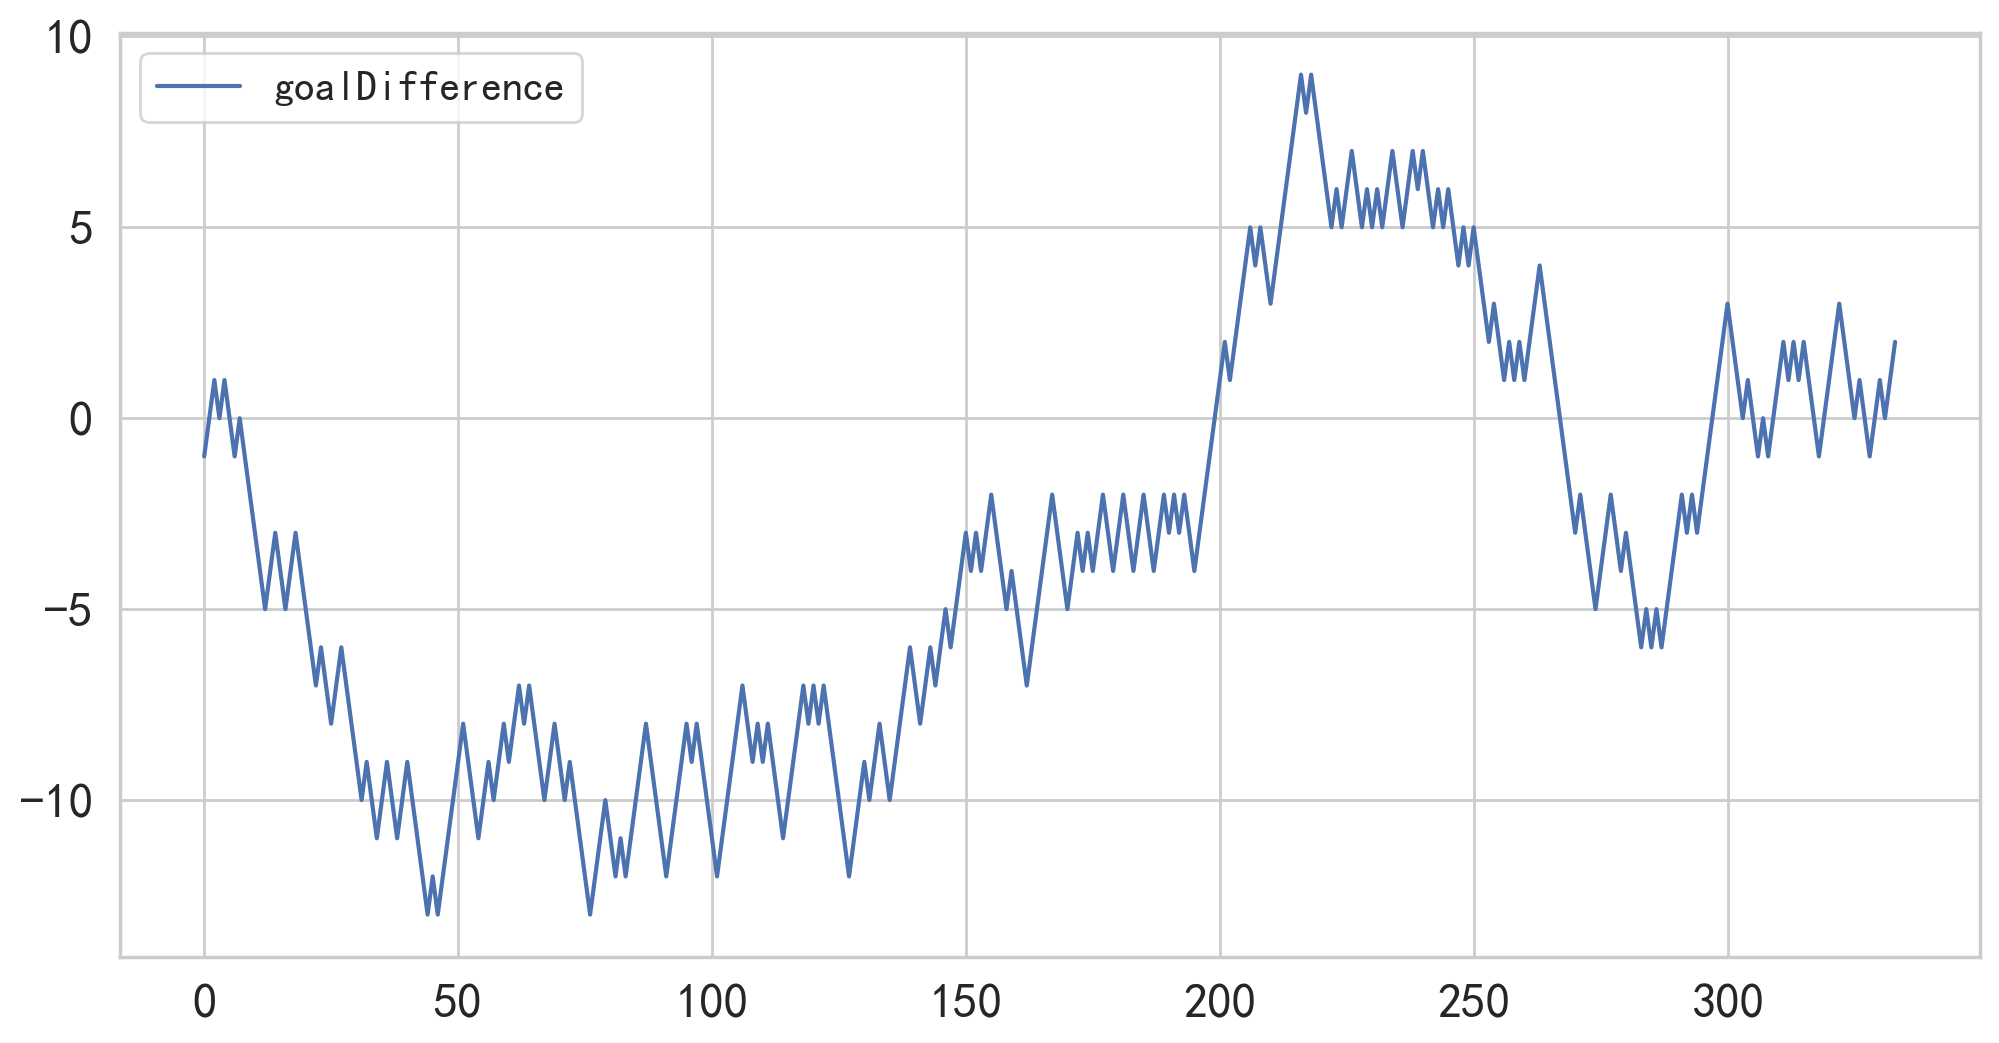

In [132]:
diffSearch = pred_Momentum
originIndex
for index, row in diffSearch.iterrows():
    diffSearch.at[index,'goalDifference'] = df.iloc[originIndex[index]]['p1_points_won'] - df.iloc[originIndex[index]]['p2_points_won'];
plt.figure()
diffSearch['goalDifference'].plot(kind = "line",figsize = (12,6)) #颜色,matplotlib
plt.legend(loc='upper left', fontsize=15)
plt.show()

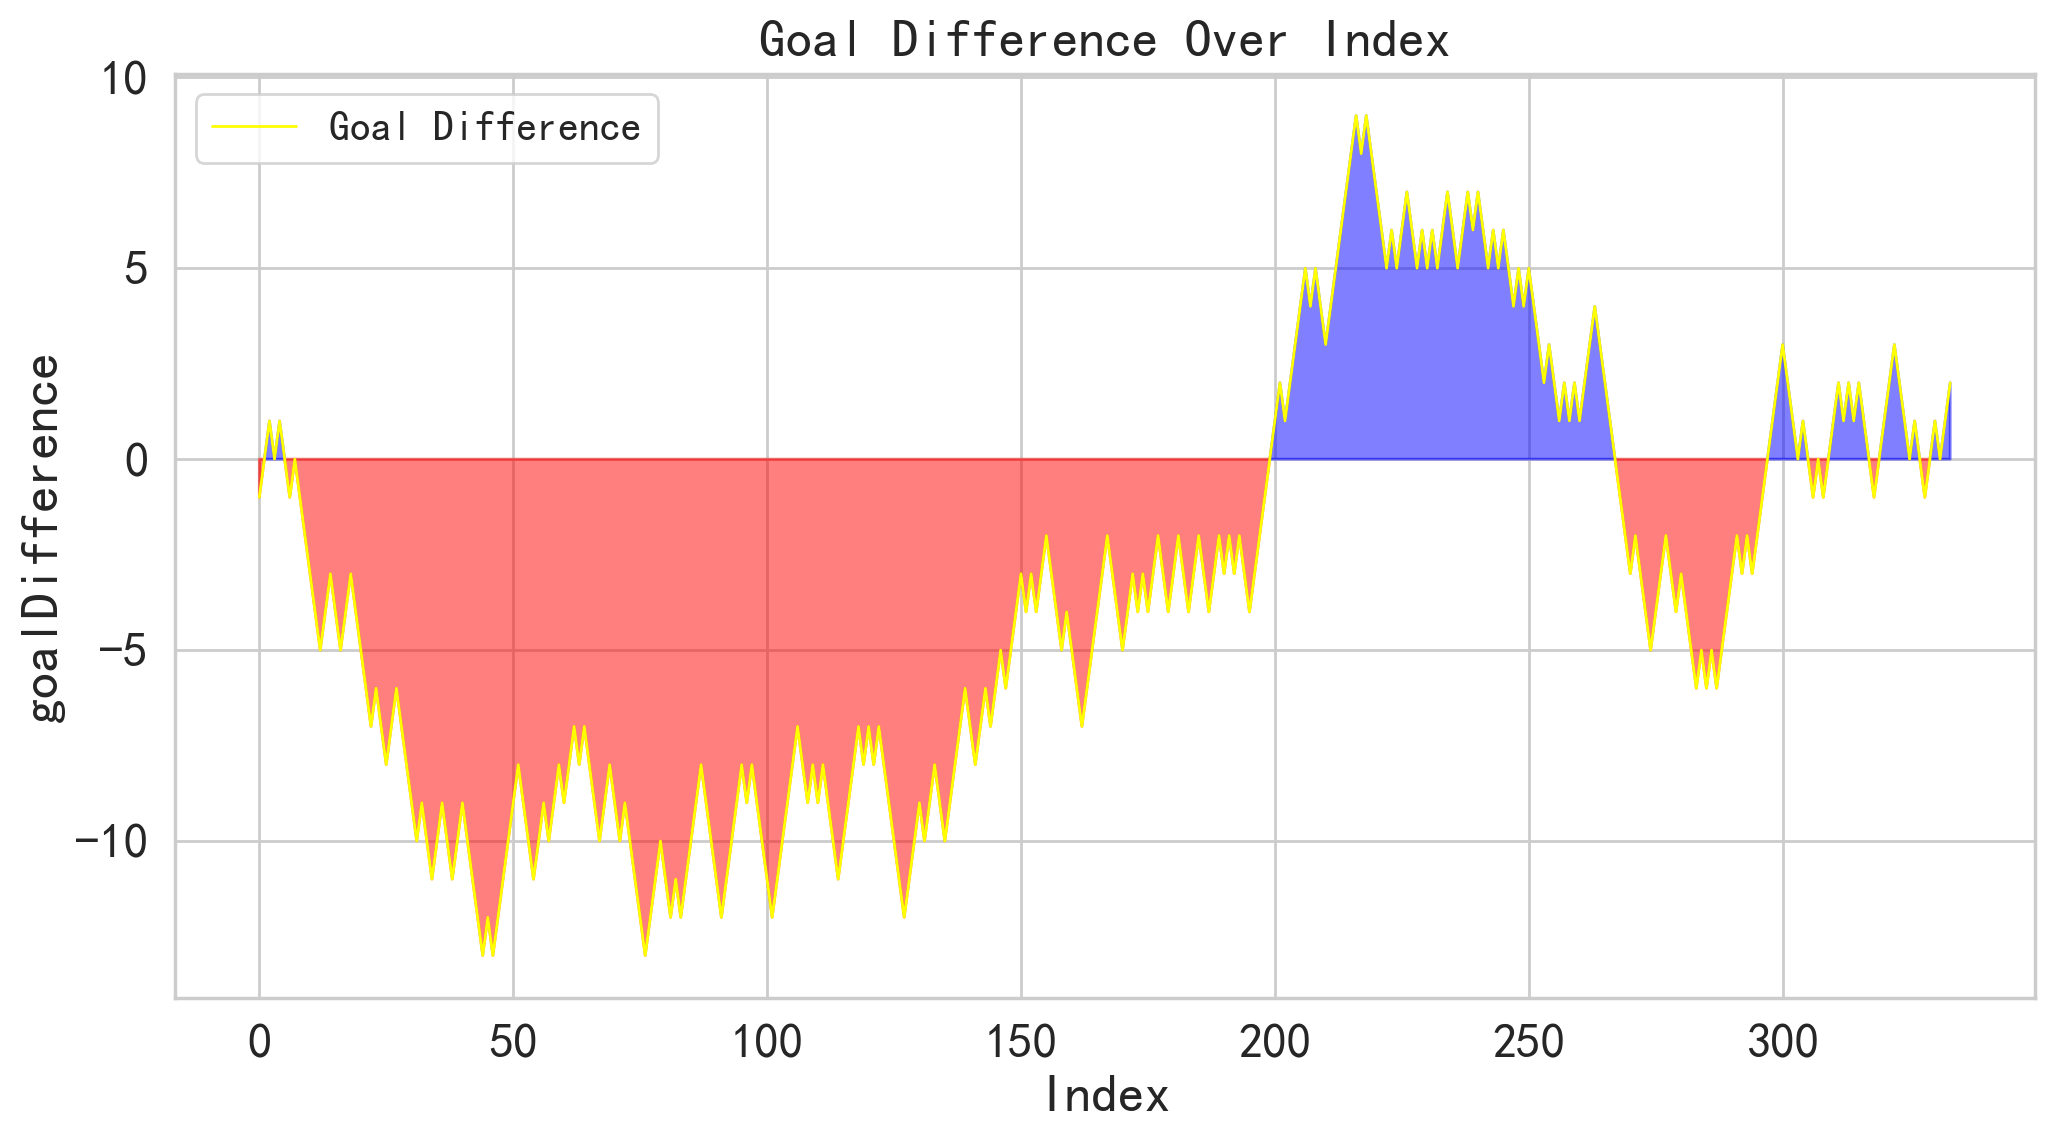

In [133]:
import numpy as np

plt.figure(figsize=(12, 6))

# 绘制goalDifference的线图，高于0的部分涂蓝色，低于0的部分涂红色
diffSearch['goalDifference'].plot(kind='line', color='yellow', linewidth=1, label='Goal Difference')

# 获取goalDifference列的最大值和最小值
max_value = diffSearch['goalDifference'].max()
min_value = diffSearch['goalDifference'].min()

# 使用fill_between填充高于0的区域为蓝色，低于0的区域为红色
plt.fill_between(diffSearch.index, diffSearch['goalDifference'], where=(diffSearch['goalDifference'] >= 0), interpolate=True, color='blue', alpha=0.5)
plt.fill_between(diffSearch.index, diffSearch['goalDifference'], where=(diffSearch['goalDifference'] < 0), interpolate=True, color='red', alpha=0.5)

plt.xlabel('Index')
plt.ylabel('goalDifference')
plt.title('Goal Difference Over Index')
plt.legend(loc='upper left', fontsize=15)
plt.grid(True)
plt.show()


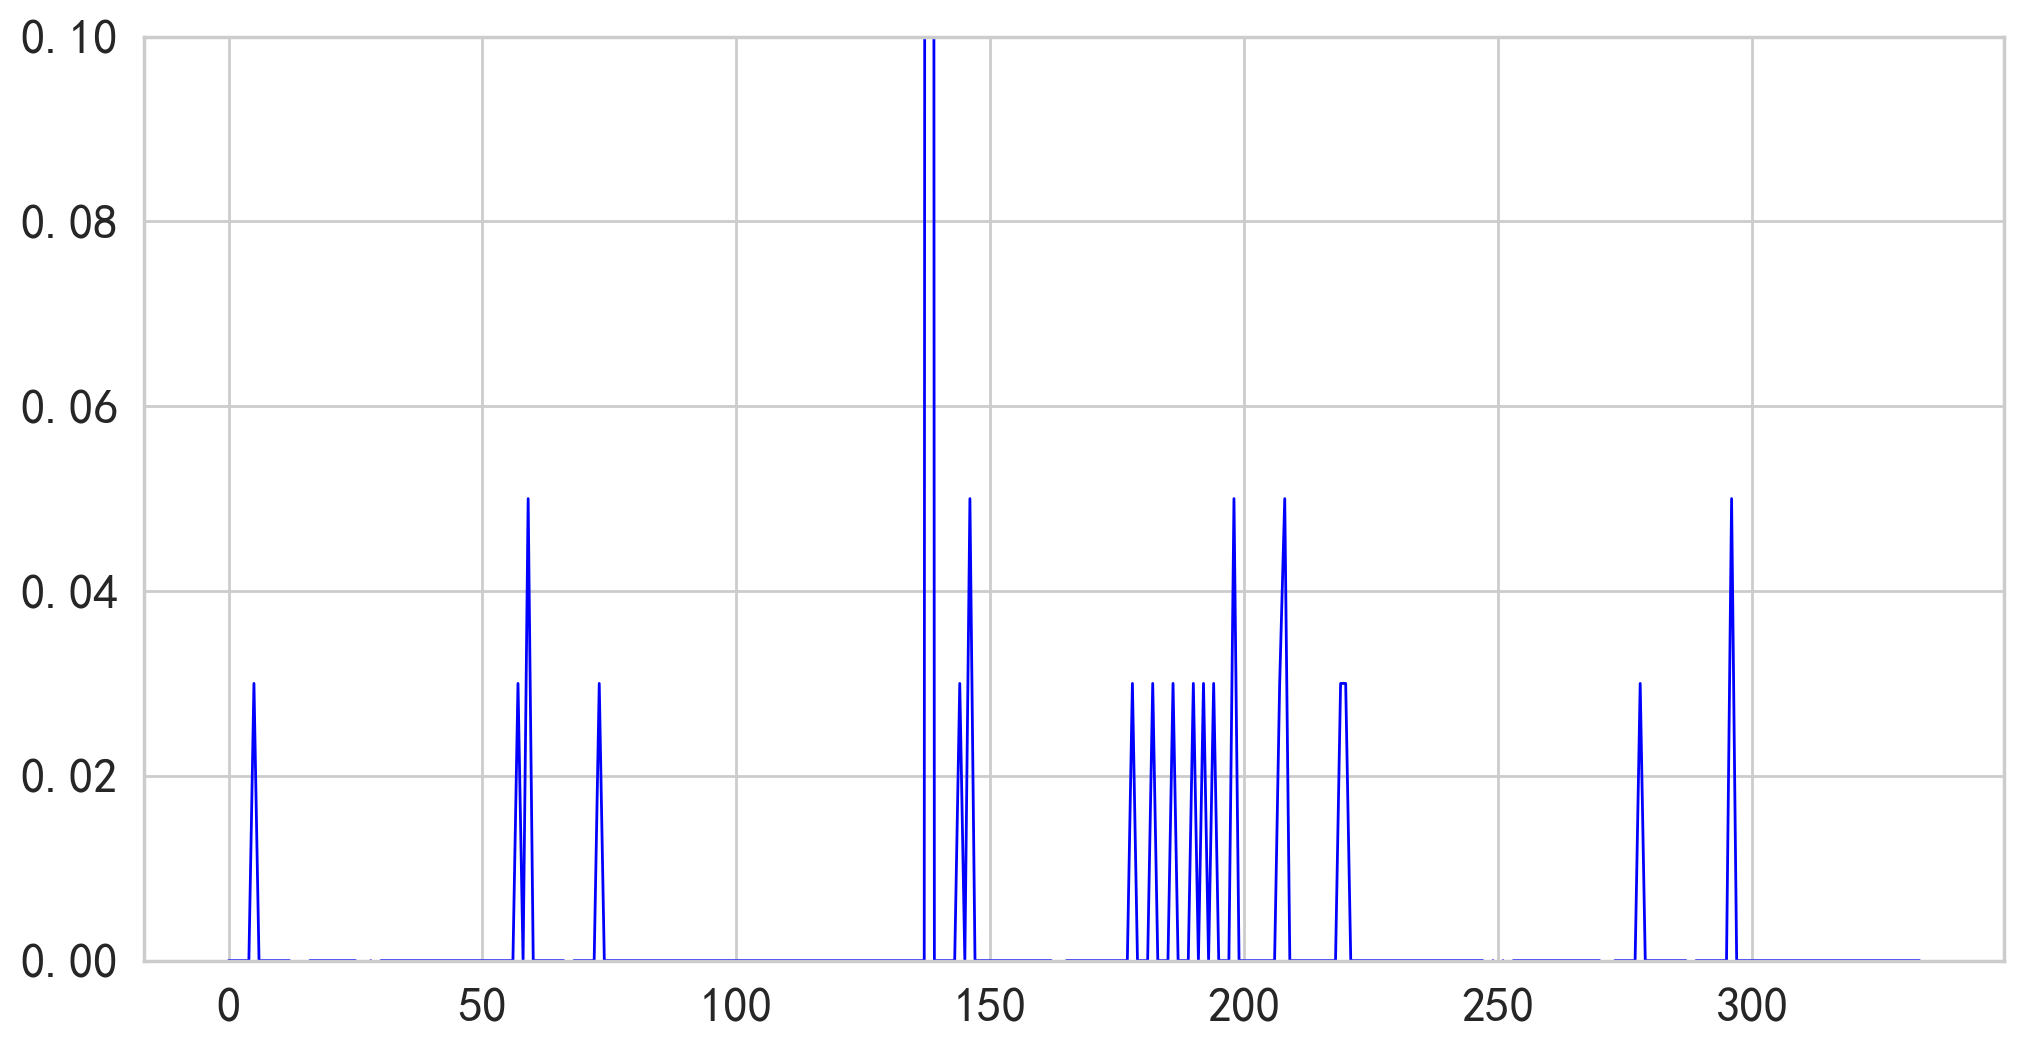

In [134]:
# 计算势头差值
for index, row in diffSearch.iterrows():
    diffSearch.at[index,'momentumDiff'] = datasetloadP1.iloc[originIndex[index]]['momentValue'] - datasetloadP2.iloc[originIndex[index]]['momentValue'];

plt.figure(figsize=(12, 6))


In [ ]:
# 绘制goalDifference的线图，高于0的部分涂蓝色，低于0的部分涂红色
diffSearch['momentumDiff'].plot(kind='line', color='blue', linewidth=1, label='Goal Difference')
plt.ylim(0,0.1);
plt.show();


#### 第三题